In [1]:
import hdbscan
import matplotlib
import matplotlib.category
import matplotlib.colors
import matplotlib.lines
import matplotlib.markers
import matplotlib.patches
import matplotlib.pyplot
import matplotlib.transforms
import numpy
import pandas
import scipy
import scipy.sparse.csgraph
import scipy.spatial.distance
import scipy.stats
import seaborn
import sgt
import statsmodels
import statsmodels.discrete
import statsmodels.discrete.discrete_model
import statsmodels.regression
import statsmodels.regression.mixed_linear_model
import statsmodels.robust
import statsmodels.robust.robust_linear_model
import statsmodels.stats
import statsmodels.stats.outliers_influence
import statsmodels.tools
import statsmodels.tools.sm_exceptions
import statsmodels.tools.tools
import umap

## Load Pilot datasets

In [2]:
participant_df_pilot = pandas.read_parquet("djangosite/dumps/pilot/participant.parquet")
rule_df_pilot = pandas.read_parquet("djangosite/dumps/pilot/rule.parquet")
result_df_pilot = pandas.read_parquet("djangosite/dumps/pilot/result.parquet")
update_df_pilot = pandas.read_parquet("djangosite/dumps/pilot/update.parquet")
change_df_pilot = pandas.read_parquet("djangosite/dumps/pilot/change.parquet")

## Load datasets

In [3]:
participant_df = pandas.read_parquet("djangosite/dumps/participant.parquet")
rule_df = pandas.read_parquet("djangosite/dumps/rule.parquet")
result_df = pandas.read_parquet("djangosite/dumps/result.parquet")
update_df = pandas.read_parquet("djangosite/dumps/update.parquet")
change_df = pandas.read_parquet("djangosite/dumps/change.parquet")

In [4]:
all_scenarios = sorted(rule_df["Scenario"].unique().tolist())
all_users = sorted(rule_df["User ID"].unique().tolist())

In [5]:
rule_df["Limited Proxy"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q000" not in x
)
rule_df["Successful Malicious Action"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q001" not in x
)
rule_df["Alert Throttling"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q002" not in x
)
rule_df["Exceptions"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q003" not in x
)
rule_df["Generalized Characteristic"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q004" not in x
)
rule_df["Generalized Position"] = rule_df["Design Principle Issues"].apply(
    lambda x: x is not None and "Q005" not in x
)

In [6]:
rule_df["User Had Design Principle Instruction"] = rule_df["User ID"].apply(
    lambda x: participant_df.loc[x, "Had Design Principle Instruction"]
)

# Numbers and Plots for the paper

In [7]:
print("Participants: ", participant_df["Participated"].sum())
print("Rules: ", rule_df.index.to_series().count())
print("Valid Rules: ", (rule_df["Valid"]).sum())
print("Changes: ", change_df.index.to_series().count())
print("Tests ran: ", result_df.index.to_series().count())

Participants:  60
Rules:  4513
Valid Rules:  3146
Changes:  5176
Tests ran:  15751


In [8]:
mask = participant_df["Participated"]
mask = mask & participant_df["Control Question Correct"]

print(participant_df[mask]["ISCED"].value_counts(normalize=True))
print()
print(participant_df[mask]["Gender"].value_counts(normalize=True))
print()
# print(participant_df[mask]["Learned About CTF"].value_counts(normalize=True))

ISCED
6.0    0.850000
3.0    0.066667
7.0    0.066667
4.0    0.016667
Name: proportion, dtype: float64

Gender
Male                        0.800000
Female                      0.166667
I prefer not to disclose    0.016667
Other                       0.016667
Name: proportion, dtype: float64



In [9]:
participant_df[participant_df["Participated"]]["Best Overall F1 During CTF"].describe()

count    60.000000
mean      0.673500
std       0.154194
min       0.320000
25%       0.577500
50%       0.670000
75%       0.732500
max       1.000000
Name: Best Overall F1 During CTF, dtype: float64

In [10]:
participant_df[participant_df["Participated"]][
    "Best Overall Precision During CTF"
].describe()

count    60.000000
mean      0.842833
std       0.157309
min       0.570000
25%       0.707500
50%       0.850000
75%       1.000000
max       1.000000
Name: Best Overall Precision During CTF, dtype: float64

In [11]:
participant_df[participant_df["Participated"]][
    "Best Overall Recall During CTF"
].describe()

count    60.000000
mean      0.592833
std       0.194589
min       0.190000
25%       0.470000
50%       0.530000
75%       0.740000
max       1.000000
Name: Best Overall Recall During CTF, dtype: float64

In [12]:
participant_df[participant_df["Participated"]][
    "Overall Design Principle Issues Count for with Final Best Submission During CTF"
].describe()

count    60.000000
mean     10.350000
std       3.574035
min       0.000000
25%       8.000000
50%      10.500000
75%      13.000000
max      16.000000
Name: Overall Design Principle Issues Count for with Final Best Submission During CTF, dtype: float64

In [13]:
participant_df[participant_df["Participated"]][
    "Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF"
].describe()

count      42.000000
mean     2930.764525
std      1335.699543
min       687.759064
25%      2404.311437
50%      2743.397801
75%      3296.172832
max      6666.731463
Name: Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF, dtype: float64

In [14]:
rule_df.groupby("User ID")["Rule"].count().describe()

count     60.000000
mean      75.216667
std       48.421557
min       15.000000
25%       43.000000
50%       68.000000
75%       97.000000
max      337.000000
Name: Rule, dtype: float64

In [15]:
(
    rule_df[rule_df["Valid"]].groupby("User ID")["Rule"].count()
    / rule_df.groupby("User ID")["Rule"].count()
).describe()

count    60.000000
mean      0.695948
std       0.111435
min       0.416667
25%       0.605169
50%       0.737490
75%       0.777759
max       0.865385
Name: Rule, dtype: float64

In [16]:
rule_df[rule_df["Valid"] & rule_df["Final Valid Submitted Rule During CTF"]].groupby(
    ["Scenario"]
)["F1"].describe()

,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Baby,60.0,0.983333,0.129099,0.0,1.00,1.00,1.00,1.0
Malspam Download,54.0,0.476111,0.264493,0.0,0.40,0.40,0.67,1.0
PHP Information Disclosure,53.0,0.594151,0.225580,0.0,0.56,0.59,0.62,1.0
RAT,56.0,0.596429,0.282890,0.0,0.50,0.80,0.80,1.0


In [17]:
rule_df[rule_df["Valid"] & rule_df["Final Valid Submitted Rule During CTF"]].groupby(
    ["Scenario"]
)["Precision"].describe()

,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Baby,60.0,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0
Malspam Download,54.0,0.958333,0.159229,0.250000,1.000000,1.0,1.0,1.0
PHP Information Disclosure,53.0,0.876011,0.158579,0.571429,0.785714,1.0,1.0,1.0
RAT,56.0,0.941964,0.202210,0.000000,1.000000,1.0,1.0,1.0


In [18]:
rule_df[rule_df["Valid"] & rule_df["Final Valid Submitted Rule During CTF"]].groupby(
    ["Scenario"]
)["Recall"].describe()

,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Baby,60.0,0.983333,0.129099,0.0,1.000000,1.000000,1.000000,1.0
Malspam Download,54.0,0.370370,0.273606,0.0,0.250000,0.250000,0.500000,1.0
PHP Information Disclosure,53.0,0.509434,0.254857,0.0,0.454545,0.454545,0.545455,1.0
RAT,56.0,0.523810,0.268608,0.0,0.333333,0.666667,0.666667,1.0


In [19]:
rule_df[rule_df["Valid"] & rule_df["Final Valid Submitted Rule During CTF"]].groupby(
    ["Scenario"]
)["Design Principle Issues Count"].describe()

,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Baby,56.0,2.946429,0.672029,2.0,2.75,3.0,3.0,4.0
Malspam Download,51.0,3.058824,0.881176,1.0,3.00,3.0,4.0,4.0
PHP Information Disclosure,48.0,3.187500,0.959970,1.0,2.75,3.0,4.0,5.0
RAT,52.0,3.192308,0.793070,1.0,3.00,3.0,4.0,4.0


In [20]:
rule_df[
    rule_df["Valid"] & rule_df["First Submission to Pass Visible Tests During CTF"]
].groupby(["Scenario"])["Seconds Worked Towards Scenario Submission"].describe()

,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Baby,60.0,429.756746,592.107895,0.000000,53.153793,204.363994,555.623638,3448.843952
Malspam Download,47.0,1272.524902,971.650271,116.277547,519.878918,950.808238,1735.469959,3869.371190
PHP Information Disclosure,51.0,667.364042,684.808660,108.831190,284.263045,461.611158,777.121067,4193.251989
RAT,52.0,967.898059,689.304361,56.738158,422.879890,742.088894,1457.161088,3109.141465


In [21]:
rule_df.groupby(["Scenario", "User ID"])["Rule"].count().unstack().T.describe()

Scenario,Baby,Malspam Download,PHP Information Disclosure,RAT
count,60.000000,54.000000,53.000000,57.000000
mean,22.283333,21.814815,16.773585,19.456140
std,17.821232,25.341497,17.893533,17.358685
min,2.000000,2.000000,2.000000,1.000000
25%,11.000000,7.250000,4.000000,6.000000
50%,16.500000,15.000000,9.000000,14.000000
75%,28.000000,28.500000,23.000000,24.000000
max,95.000000,167.000000,74.000000,69.000000


In [22]:
(
    rule_df[rule_df["Valid"]]
    .groupby(["Scenario", "User ID"])["Rule"]
    .count()
    .unstack()
    .T
    / rule_df.groupby(["Scenario", "User ID"])["Rule"].count().unstack().T
).describe()

Scenario,Baby,Malspam Download,PHP Information Disclosure,RAT
count,60.000000,54.000000,53.000000,56.000000
mean,0.664948,0.736550,0.734338,0.776239
std,0.189954,0.218957,0.215549,0.182695
min,0.285714,0.210526,0.222222,0.333333
25%,0.545455,0.605172,0.666667,0.666667
50%,0.683036,0.766968,0.750000,0.785362
75%,0.800000,0.913399,0.888889,0.953869
max,1.000000,1.000000,1.000000,1.000000


Processing Best Overall F1 Invisible During CTF

VIF for const: 69.51502486623902
VIF for ISCED: 1.0718306826493063
VIF for Self Graded CTF: 1.2371917163993684
VIF for Quiz Networking Total: 1.3723628074031282
VIF for Quiz OCS Total: 1.424009875486445
VIF for Quiz Wireshark Total: 1.6987495120113618
VIF for Quiz IDS Paradigms: 1.3987452087710837
VIF for Quiz Suricata Total: 1.3137283389273193

                             Robust linear Model Regression Results                             
Dep. Variable:     Best Overall F1 Invisible During CTF   No. Observations:                   60
Model:                                              RLM   Df Residuals:                       52
Method:                                            IRLS   Df Model:                            7
Norm:                                            HuberT                                         
Scale Est.:                                         mad                                         
Cov Type:            

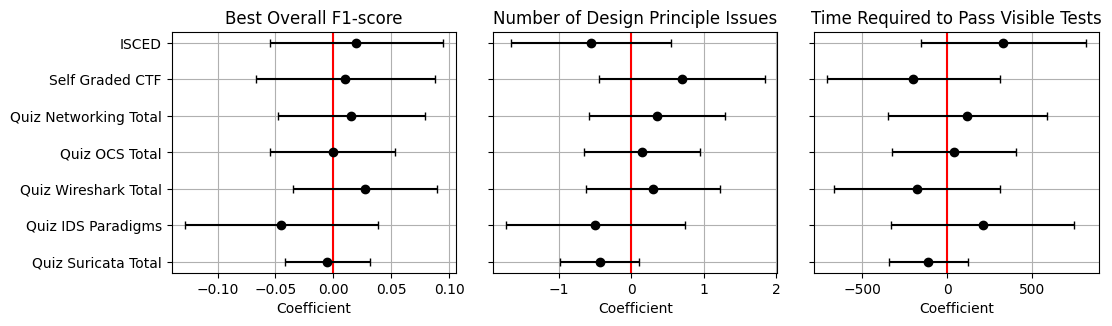

In [23]:
x_cols = [
    "ISCED",
    # "Quiz Total",
    "Self Graded CTF",
    # "Quiz Networking TCP",
    # "Quiz Networking TLS",
    # "Quiz Networking Scanning",
    "Quiz Networking Total",
    # "Quiz OCS Scanning",
    # "Quiz OCS XSS",
    # "Quiz OCS Persistence",
    "Quiz OCS Total",
    # "Quiz Wireshark Features",
    # "Quiz Wireshark Filter",
    "Quiz Wireshark Total",
    "Quiz IDS Paradigms",
    # "Quiz Suricata Functionality",
    # "Quiz Suricata Match",
    # "Quiz Suricata Docs",
    "Quiz Suricata Total",
    # "Had Design Principle Instruction",
    # "Watched Lecture Before CTF",
    # "Had Design Principle Instruction x Watched Lecture Before CTF",
    # "Overall Design Principle Issues Count for with Final Best Submission During CTF",
]

y_cols = [
    # "Baby Best F1 During CTF",
    "PHP Information Disclosure Best F1 During CTF",
    "Malspam Download Best F1 During CTF",
    "RAT Best F1 During CTF",
]

y_cols = [
    # "Baby Best F1 Invisible During CTF",
    "PHP Information Disclosure Best F1 Invisible During CTF",
    "Malspam Download Best F1 Invisible During CTF",
    "RAT Best F1 Invisible During CTF",
]

y_cols = [
    # "Baby Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
    "PHP Information Disclosure Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
    "Malspam Download Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
    "RAT Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
]

# y_cols = ["Participated in Scenarios Number", "Passed Visible Tests in Scenarios Number"]

y_cols = [
    # "Best Overall Precision During CTF",
    # "Best Overall Recall During CTF",
    # "Best Overall F1 During CTF",
    "Best Overall F1 Invisible During CTF",
    "Overall Design Principle Issues Count for with Final Best Submission During CTF",
    "Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
]

with_constant = True

mask = participant_df["Participated"]
mask = mask & participant_df["Control Question Correct"]
# mask = mask & ~participant_df["Had Design Principle Instruction"]
# mask = mask & ~participant_df["Had Design Principle Instruction"] & participant_df["Watched Lecture Before CTF"]
# mask = mask & participant_df["Had Design Principle Instruction"] & participant_df["Watched Lecture Before CTF"]
# mask = mask & participant_df["Watched Lecture Before CTF"]
# mask = mask & (participant_df["Participated in Scenarios Number"] == 4)
# mask = mask & (participant_df["Passed Visible Tests in Scenarios Number"] == 4)
# mask = mask & (participant_df["Best Overall F1 Visible During CTF"] == 1.0)

df_coef = pandas.DataFrame()
df_ci = pandas.DataFrame(columns=x_cols).astype(object)

# Plot the orbital period with horizontal boxes
for j, y_col in enumerate(y_cols):
    print("Processing", y_col)
    print("")

    extra_mask = ~participant_df[y_col].isna()
    X = participant_df.loc[mask & extra_mask, x_cols].map(lambda x: float(x))
    if with_constant:
        X = statsmodels.tools.tools.add_constant(X)
    y = participant_df.loc[mask & extra_mask, y_col]

    for i, x_col in enumerate(X.columns):
        vif = statsmodels.stats.outliers_influence.variance_inflation_factor(X, i)
        print(
            f"VIF for {x_col}: {vif}",
        )

    print("")

    model = statsmodels.robust.robust_linear_model.RLM(
        endog=y, exog=X, M=statsmodels.robust.norms.HuberT()
    )
    model_results: statsmodels.robust.robust_linear_model.RLMResults = model.fit(
        maxiter=100, tol=1e-12, scale_est="mad"
    )

    # model = statsmodels.regression.mixed_linear_model.MixedLM(
    #     endog=y,
    #     exog=X,
    #     groups=participant_df.loc[mask & extra_mask, "Mixed Effects Label"],
    #     use_sqrt=False,
    # )
    # model_results = model.fit()

    print(model_results.summary())

    y_pred = model_results.predict(X)

    print("Testing for Shapiro-Wilk")
    print(
        "H0: Distribution of residuals is normally distributed",
    )
    print(
        "Rejection of H0 (p<0.05) implies the model does not fit the data well.",
    )
    shapiro_results = scipy.stats.shapiro(y - y_pred)
    good_fit_shapiro = shapiro_results.pvalue > 0.05
    print(shapiro_results)

    print("")

    print("Testing for Kolmogorov-Smirnov")
    print(
        "H0: Distribution of predicted target_feature and actual target_feature are identical.",
    )
    print(
        "Rejection of H0 (p<0.05) implies the model does not fit the data well.",
    )
    ks_results = scipy.stats.kstest(
        y,
        y_pred,
        alternative="two-sided",
        method="exact",
    )
    good_fit_ks = ks_results.pvalue > 0.05
    print(ks_results)

    print("\n")

    for i, x_col in enumerate(x_cols):
        coef = model_results.params[x_col]
        df_coef.loc[y_col, x_col] = coef

        ci1 = model_results.conf_int(0.05).loc[x_col, 0]
        ci2 = model_results.conf_int(0.05).loc[x_col, 1]
        df_ci.loc[y_col, x_col] = (ci1, ci2)

MARKER = "o"
MARKER_SIZE = 5
SAME_XLIM = False

effects = df_coef.index
experiences = df_coef.columns

fig, axs = matplotlib.pyplot.subplots(
    figsize=(10, 3), ncols=len(y_cols), nrows=1, sharey=True
)
fig.tight_layout()

for group, ax in zip(effects, axs):
    ax.axvline(0.0, color="red")

for experience in experiences[::-1]:
    if experience == "Constant":
        continue
    for effect, ax in zip(effects, axs):
        if effect not in df_ci.index:
            continue
        ci = df_ci.loc[effect, experience]
        if not isinstance(ci, tuple):
            continue
        c = df_coef.loc[effect, experience]
        err = numpy.array((c - ci[0], ci[1] - c)).reshape(-1, 1)
        ax.errorbar(c, experience, xerr=err, color="black", marker="o", capsize=3)

xlim = (min(ax.get_xlim()[0] for ax in axs), max(ax.get_xlim()[1] for ax in axs))
xlim = (xlim[0] - 0.1, xlim[1] + 0.1)

for effect, ax in zip(effects, axs):
    if SAME_XLIM:
        ax.set_xlim(xlim)
    ax.grid()
    ax.set_xlabel("Coefficient")

    ax.set_title(effect)

axs[0].set_title("Best Overall F1-score")
axs[1].set_title("Number of Design Principle Issues")
axs[2].set_title("Time Required to Pass Visible Tests")

fig.savefig(
    "figures/paper/experience_effects_new.pdf",
    dpi=600,
    bbox_inches="tight",
)

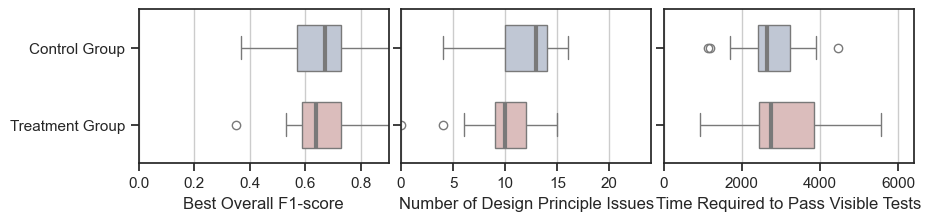

In [24]:
x_cols = [
    "Best Overall F1 During CTF",
    "Overall Design Principle Issues Count for with Final Best Submission During CTF",
    "Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
]
y_col = "Had Design Principle Instruction"

seaborn.set_theme(style="ticks")

mask = participant_df["Participated"]
mask = mask & participant_df["Watched Lecture Before CTF"]

f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 2), nrows=1, ncols=len(x_cols), sharey=True, sharex=False
)

# Plot the orbital period with horizontal boxes
for i, x_col in enumerate(x_cols):
    ax = axs[i]
    seaborn.boxplot(
        participant_df[mask],
        x=x_col,
        y=participant_df.loc[mask, y_col].astype(str),
        hue=y_col,
        # whis=[0, 100],
        width=0.6,
        palette="vlag",
        # flierprops={"markersize": 0},
        medianprops={"linewidth": 3},
        ax=ax,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    ax.get_legend().remove()
    # ax.set_xlim(0, 1)
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Control Group", "Treatment Group"])

axs[0].set_xlim(0.0, 0.9)
axs[1].set_xlim(0, 4 * 6)
axs[2].set_xlim(0, 6400)

axs[0].set_xlabel("Best Overall F1-score")
axs[1].set_xlabel("Number of Design Principle Issues")
axs[2].set_xlabel("Time Required to Pass Visible Tests")

f.subplots_adjust(hspace=0.05, wspace=0.05)

# seaborn.despine(trim=False, left=True)
# seaborn.despine(trim=True, left=True)

f.savefig(
    "figures/paper/control_treatment_comparison.pdf", bbox_inches="tight", dpi=600
)

In [25]:
x_cols = [
    "Best Overall F1 During CTF",
    "Overall Design Principle Issues Count for with Final Best Submission During CTF",
    "Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF",
]
y_col = "Had Design Principle Instruction"

seaborn.set_theme(style="ticks")

mask = participant_df["Participated"]
mask = mask & participant_df["Watched Lecture Before CTF"]
for i, x_col in enumerate(x_cols):
    group_treatment = participant_df.loc[mask & participant_df[y_col], x_col].values
    group_control = participant_df.loc[mask & ~participant_df[y_col], x_col].values

    print(x_col, "\n\n")
    print("Less", "\n")
    print(
        scipy.stats.mannwhitneyu(
            group_treatment,
            group_control,
            alternative="less",
            method="asymptotic",
            nan_policy="omit",
        ),
        "\n\n",
    )
    print("Greater", "\n")
    print(
        scipy.stats.mannwhitneyu(
            group_treatment,
            group_control,
            alternative="greater",
            method="asymptotic",
            nan_policy="omit",
        ),
        "\n\n\n",
    )

Best Overall F1 During CTF 


Less 

MannwhitneyuResult(statistic=np.float64(216.5), pvalue=np.float64(0.4648493238681082)) 


Greater 

MannwhitneyuResult(statistic=np.float64(216.5), pvalue=np.float64(0.5451555080522563)) 



Overall Design Principle Issues Count for with Final Best Submission During CTF 


Less 

MannwhitneyuResult(statistic=np.float64(150.5), pvalue=np.float64(0.03892947854558683)) 


Greater 

MannwhitneyuResult(statistic=np.float64(150.5), pvalue=np.float64(0.9631617212336685)) 



Overall Seconds Worked Towards First Submission to Pass Visible Tests During CTF 


Less 

MannwhitneyuResult(statistic=np.float64(144.0), pvalue=np.float64(0.7588963657536292)) 


Greater 

MannwhitneyuResult(statistic=np.float64(144.0), pvalue=np.float64(0.25309879739649055)) 





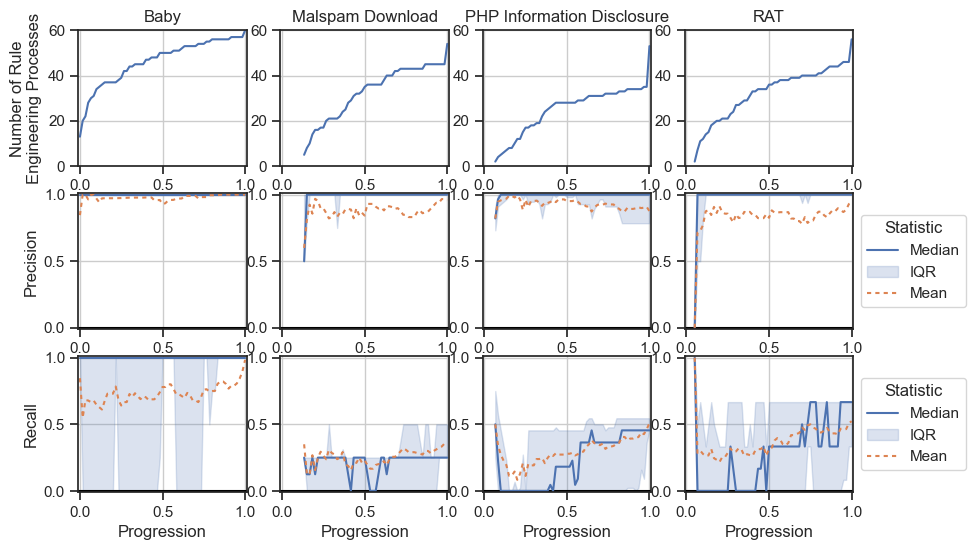

In [26]:
x_col = "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"

# "Precision Visible", "Recall Visible", "F1 Visible", "F1 Invisible",
y_cols = ["Precision", "Recall"]

mask = rule_df["Valid"] & rule_df["Submitted During CTF"]
for y_col in y_cols:
    mask = mask & ~rule_df[y_col].isna()

f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 2 * (1 + len(y_cols))),
    nrows=1 + len(y_cols),
    ncols=rule_df.loc[mask]["Scenario"].nunique(),
    sharex=False,
    sharey=False,
)

plot_df = pandas.DataFrame()

# Collect data for plotting
for i, scenario in enumerate(sorted(rule_df.loc[mask, "Scenario"].unique())):
    extra_mask = rule_df["Scenario"] == scenario

    for user_id in rule_df.loc[mask & extra_mask, "User ID"].unique():
        extra_extra_mask = rule_df["User ID"] == user_id

        if len(rule_df.loc[mask & extra_mask & extra_extra_mask, y_col].index) == 0:
            continue

        x = rule_df.loc[mask & extra_mask & extra_extra_mask, x_col]

        y = rule_df.loc[mask & extra_mask & extra_extra_mask, y_col]

        new_df = pandas.DataFrame(
            {x_col: x}
            | {
                y_col: rule_df.loc[mask & extra_mask & extra_extra_mask, y_col]
                for y_col in y_cols
            }
        )
        new_df[x_col] = pandas.to_datetime(new_df[x_col], unit="m")
        new_df = new_df.reset_index().set_index(x_col)
        new_df = new_df.resample("s", origin="epoch").bfill()
        new_df.drop(columns=["Rule ID"])
        new_df["Scenario"] = scenario
        new_df["User ID"] = user_id
        new_df = new_df.reset_index(level=x_col)
        new_df = new_df.reset_index(drop=True)

        # if new_df[y_col+ " Offset"].std() > 0.:
        #     raise RuntimeError()

        plot_df = pandas.concat([plot_df, new_df])


def percentile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
    return percentile_


plot_df = (
    plot_df.groupby([x_col, "Scenario"])
    .agg(
        {
            y_col: [
                "mean",
                "median",
                "std",
                "count",
                percentile(0.05),
                percentile(0.25),
                percentile(0.75),
                percentile(0.95),
            ]
            for y_col in y_cols
        }
    )
    .reset_index()
)
plot_df[x_col] = plot_df[x_col].apply(lambda x: x.timestamp() / 60)
plot_df.columns = plot_df.columns.map("|".join).str.strip("|")

for i, scenario in enumerate(sorted(plot_df["Scenario"].unique())):
    mask = plot_df["Scenario"] == scenario
    if mask.sum() == 0:
        continue

    # Plot the data count
    ax = axs[0][i]

    seaborn.lineplot(
        x=plot_df.loc[mask, x_col],
        y=plot_df.loc[mask, y_col + "|count"],
        # color=".3",
        color=seaborn.color_palette()[0],
        errorbar=("ci", False),
        ax=ax,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, len(participant_df[participant_df["Participated"]].index) + 0.01)
    # ax.set_xlabel("Progression")
    ax.set_xlabel(None)
    if i == 0:
        ax.set_ylabel("Number of Rule\nEngineering Processes")
    else:
        ax.set_ylabel(None)
    ax.set_title(scenario)
    # ax.get_legend().remove()

    # Plot the data aggregates
    for j, y_col in enumerate(y_cols):
        ax = axs[1 + j][i]
        ax.axhline(0, color="black")

        g = seaborn.lineplot(
            x=plot_df.loc[mask, x_col],
            y=plot_df.loc[mask, y_col + "|median"],
            color=seaborn.color_palette()[0],
            errorbar=("ci", False),
            label="Median",
            ax=ax,
        )

        # ax.fill_between(plot_df.loc[mask, x_col], plot_df.loc[mask, y_col + " Offset|percentile_05"], plot_df.loc[mask, y_col + " Offset|percentile_95"], color=seaborn.color_palette()[0], alpha=0.2)
        ax.fill_between(
            plot_df.loc[mask, x_col],
            plot_df.loc[mask, y_col + "|percentile_25"],
            plot_df.loc[mask, y_col + "|percentile_75"],
            color=seaborn.color_palette()[0],
            alpha=0.2,
            label="IQR",
        )
        # ax.fill_between(plot_df.loc[mask, x_col], plot_df.loc[mask, y_col + " Offset|mean"]-plot_df.loc[mask, y_col + " Offset|std"], plot_df.loc[mask, y_col + " Offset|mean"]+plot_df.loc[mask, y_col + " Offset|std"], color=seaborn.color_palette()[0], alpha=0.2)

        g = seaborn.lineplot(
            x=plot_df.loc[mask, x_col],
            y=plot_df.loc[mask, y_col + "|mean"],
            color=seaborn.color_palette()[1],
            dashes=(2, 2),
            errorbar=("ci", False),
            label="Mean",
            ax=ax,
        )

        # Tweak the visual presentation
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_xlabel("Progression")
        if i == 0:
            # if j == 0:
            #     ax.set_ylabel("F1-Score on Visible Tests")
            # if j == 1:
            #     ax.set_ylabel("F1-Score on Invisible Tests")
            if j == 0:
                ax.set_ylabel("Precision")
            if j == 1:
                ax.set_ylabel("Recall")
        else:
            ax.set_ylabel(None)

        if i in [3]:
            ax.legend(title="Statistic", loc="center left", bbox_to_anchor=(1, 0.5))
        else:
            ax.get_legend().remove()

f.savefig("figures/paper/progression.pdf", bbox_inches="tight", dpi=600)

In [27]:
rule_df[
    rule_df["First Submission to Pass Visible Tests During CTF"]
    & rule_df["Final Valid Submitted Rule During CTF"]
].groupby(["Scenario"])["Rule"].count()

Scenario
Baby                           8
Malspam Download              22
PHP Information Disclosure    27
RAT                           20
Name: Rule, dtype: int64

In [28]:
for i in rule_df[
    (rule_df["Precision"] == 1.0) & (rule_df["Recall"] == 0.0) & rule_df["Valid"]
]["Rule"]:
    print(i, "\n")

alert dns any any -> any any (msg:"Baby DNS detectme.foobar"; sid:1; content:"detectme.foobar";) 

alert dns any any -> any any (msg:"DNS request to detectme.foobar detected"; dns.query; content:"edtectme.foobar"; nocase; endswith; flow:to_server; sid:1001; rev:1;) 

alert dns any any -> any any (msg:"DNS request for detectme.foobar"; content:"detectme.foobar";  sid:1;) 

alert dns any any -> any any (msg:"baby";content:"detectme.foobar";sid:1;) 

alert dns any any -> any any (msg:"baby scenario dns detectme.foobar"; content:"detectme.foobar"; sid:1;) 

alert dns any any -> any any (msg:"DNS request for detectme.foobar"; content:"detectme.foobar";  sid:1000000;) 

alert dns 192.168.179.52 any -> 62.179.104.196 any (msg:"baby";content:"detectme.foobar";sid:1;) 

alert http 192.168.179.52 59163 <>  62.179.104.104 53 (msg:"dns request"; content: "detectme.foobar"; sid: 1;) 

alert dns any any -> any  any (msg:"Baby";content:"detectme.foobar"; sid:1;) 

alert dns any any -> any  any (msg:"

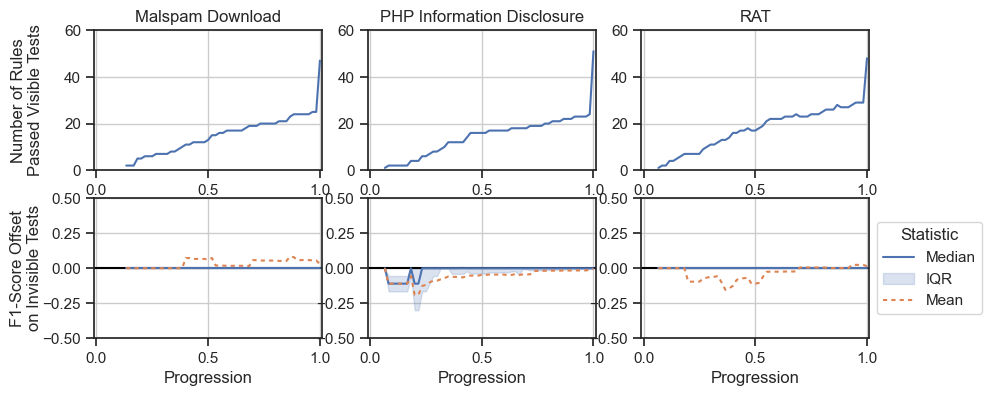

In [29]:
x_col = "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"

y_col = "F1 Invisible"

mask = (
    ~rule_df[y_col].isna()
    & rule_df["Submitted During CTF"]
    & (rule_df["F1 Visible"] == 1.0)
)

mask = (
    ~rule_df[y_col].isna()
    & rule_df["Valid"]
    & rule_df["Submitted During CTF"]
    & (rule_df["F1 Visible"] == 1.0)
)

f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 4),
    nrows=2,
    ncols=rule_df.loc[mask]["Scenario"].nunique(),
    sharex=False,
    sharey=False,
)

plot_df = pandas.DataFrame()

# Collect data for plotting
for i, scenario in enumerate(
    sorted(
        rule_df.loc[
            mask & ~rule_df["First Submission to Pass Visible Tests During CTF"],
            "Scenario",
        ].unique()
    )
):
    extra_mask = rule_df["Scenario"] == scenario

    for user_id in rule_df.loc[mask & extra_mask, "User ID"].unique():
        extra_extra_mask = rule_df["User ID"] == user_id

        if len(rule_df.loc[mask & extra_mask & extra_extra_mask, y_col].index) == 0:
            continue

        x = rule_df.loc[mask & extra_mask & extra_extra_mask, x_col]

        start_y = rule_df.loc[mask & extra_mask & extra_extra_mask, y_col].iloc[0]
        y = rule_df.loc[mask & extra_mask & extra_extra_mask, y_col] - start_y

        new_df = pandas.DataFrame({x_col: x, y_col + " Offset": y})
        new_df[x_col] = pandas.to_datetime(new_df[x_col], unit="m")
        new_df = new_df.reset_index().set_index(x_col)
        new_df = new_df.resample("s", origin="epoch").bfill()
        new_df.drop(columns=["Rule ID"])
        new_df["Scenario"] = scenario
        new_df["User ID"] = user_id
        new_df = new_df.reset_index(level=x_col)
        new_df = new_df.reset_index(drop=True)

        # if new_df[y_col+ " Offset"].std() > 0.:
        #     raise RuntimeError()

        plot_df = pandas.concat([plot_df, new_df])


def percentile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
    return percentile_


plot_df = (
    plot_df.groupby([x_col, "Scenario"])
    .agg(
        {
            y_col
            + " Offset": [
                "mean",
                "median",
                "std",
                "count",
                percentile(0.05),
                percentile(0.25),
                percentile(0.75),
                percentile(0.95),
            ]
        }
    )
    .reset_index()
)
plot_df[x_col] = plot_df[x_col].apply(lambda x: x.timestamp() / 60)
plot_df.columns = plot_df.columns.map("|".join).str.strip("|")

for i, scenario in enumerate(sorted(plot_df["Scenario"].unique())):
    mask = plot_df["Scenario"] == scenario
    if mask.sum() == 0:
        continue

    # Plot the data count
    ax = axs[0][i]

    seaborn.lineplot(
        x=plot_df.loc[mask, x_col],
        y=plot_df.loc[mask, y_col + " Offset|count"],
        # color=".3",
        color=seaborn.color_palette()[0],
        errorbar=("ci", False),
        ax=ax,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, len(participant_df[participant_df["Participated"]].index) + 0.01)
    # ax.set_xlabel("Progression")
    ax.set_xlabel(None)
    if i == 0:
        ax.set_ylabel("Number of Rules\nPassed Visible Tests", labelpad=15)
    else:
        ax.set_ylabel(None)
    ax.set_title(scenario)
    # ax.get_legend().remove()

    # Plot the data aggregates
    ax = axs[1][i]
    ax.axhline(0, color="black")

    g = seaborn.lineplot(
        x=plot_df.loc[mask, x_col],
        y=plot_df.loc[mask, y_col + " Offset|median"],
        color=seaborn.color_palette()[0],
        errorbar=("ci", False),
        label="Median",
        ax=ax,
    )

    # ax.fill_between(plot_df.loc[mask, x_col], plot_df.loc[mask, y_col + " Offset|percentile_05"], plot_df.loc[mask, y_col + " Offset|percentile_95"], color=seaborn.color_palette()[0], alpha=0.2)
    ax.fill_between(
        plot_df.loc[mask, x_col],
        plot_df.loc[mask, y_col + " Offset|percentile_25"],
        plot_df.loc[mask, y_col + " Offset|percentile_75"],
        color=seaborn.color_palette()[0],
        alpha=0.2,
        label="IQR",
    )
    # ax.fill_between(plot_df.loc[mask, x_col], plot_df.loc[mask, y_col + " Offset|mean"]-plot_df.loc[mask, y_col + " Offset|std"], plot_df.loc[mask, y_col + " Offset|mean"]+plot_df.loc[mask, y_col + " Offset|std"], color=seaborn.color_palette()[0], alpha=0.2)

    g = seaborn.lineplot(
        x=plot_df.loc[mask, x_col],
        y=plot_df.loc[mask, y_col + " Offset|mean"],
        color=seaborn.color_palette()[1],
        dashes=(2, 2),
        errorbar=("ci", False),
        label="Mean",
        ax=ax,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel("Progression")
    if i == 0:
        ax.set_ylabel("F1-Score Offset\non Invisible Tests", labelpad=0)
    else:
        ax.set_ylabel(None)
    

    if i in [2]:
        ax.legend(title="Statistic", loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.get_legend().remove()

f.savefig(
    "figures/paper/progression_beyond_visible_tests.pdf", bbox_inches="tight", dpi=600
)

In [30]:
for scenario in rule_df["Scenario"].unique():
    participant_df[scenario + " Phase 1 Start"] = 0.0

    def get_phase1_end(row):
        rules = rule_df[
            (rule_df["Scenario"] == scenario) & (rule_df["User ID"] == row.name)
        ]

        if len(rules) == 0:
            return numpy.nan

        t = rules.sort_values("Seconds Since First User Submission", ascending=True)[
            "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
        ].values[0]
        return t

    participant_df[scenario + " Phase 1 End"] = participant_df.apply(
        get_phase1_end, axis=1
    )

    # print(participant_df[scenario + " Phase 1 End"].describe())

    def get_phase2_start(row):
        rules = rule_df[
            (rule_df["Scenario"] == scenario)
            & (rule_df["User ID"] == row.name)
            & rule_df["Valid"]
        ]

        if len(rules) == 0:
            return numpy.nan

        t = rules.sort_values("Seconds Since First User Submission", ascending=True)[
            "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
        ].values[0]
        return t

    participant_df[scenario + " Phase 2 Start"] = participant_df.apply(
        get_phase2_start, axis=1
    )

    # print((participant_df[scenario + " Phase 2 Start"] - participant_df[scenario + " Phase 1 End"]).describe())

    def get_phase2_end(row):
        rules = rule_df[
            (rule_df["Scenario"] == scenario)
            & (rule_df["User ID"] == row.name)
            & rule_df["Valid"]
            & (rule_df["F1 Visible"] == 1.0)
        ]

        if len(rules) == 0:
            return numpy.nan

        t = rules.sort_values("Seconds Since First User Submission", ascending=True)[
            "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
        ].values[0]
        return t

    participant_df[scenario + " Phase 2 End"] = participant_df.apply(
        get_phase2_end, axis=1
    )

    # print(participant_df[scenario + " Phase 2 End"].describe())

    def get_phase3_start(row):
        rules = rule_df[
            (rule_df["Scenario"] == scenario)
            & (rule_df["User ID"] == row.name)
            & rule_df["Valid"]
            & (
                ~rule_df[
                    "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF Since Passing Visible Tests"
                ].isna()
            )
            & (~rule_df["First Submission to Pass Visible Tests During CTF"])
        ]

        if len(rules) == 0:
            return numpy.nan

        t = rules.sort_values("Seconds Since First User Submission", ascending=True)[
            "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
        ].values[0]
        return t

    participant_df[scenario + " Phase 3 Start"] = participant_df.apply(
        get_phase3_start, axis=1
    )

    # print(participant_df[scenario + " Phase 3 Start"].describe())

    participant_df[scenario + " Phase 3 End"] = participant_df[
        scenario + " Phase 3 Start"
    ].apply(lambda x: numpy.nan if numpy.isnan(x) else 1.0)

    # print(participant_df[scenario + " Phase 3 End"].describe())

In [31]:
granularity = 1000

participant_scenario_phase_rows = []

for scenario in rule_df["Scenario"].unique():
    for user_id, participant_row in participant_df.iterrows():
        for i in [i / granularity for i in range(granularity + 1)]:
            if numpy.isnan(participant_row[scenario + " Phase 1 End"]):
                phase = numpy.nan
            elif i <= participant_row[scenario + " Phase 1 End"]:
                phase = "Phase 1"
            elif i <= participant_row[scenario + " Phase 2 Start"]:
                phase = "Inbetween Phase 1 and 2"
            elif (
                numpy.isnan(participant_row[scenario + " Phase 2 End"])
                or i <= participant_row[scenario + " Phase 2 End"]
            ):
                phase = "Phase 2"
            # elif i <= participant_row[scenario + " Phase 3 Start"]:
            #     phase = "Inbetween Phase 2 and 3"
            elif i <= participant_row[scenario + " Phase 3 End"]:
                phase = "Phase 3"
            participant_scenario_phase_rows.append((user_id, scenario, i, phase))

participant_scenario_phase_df = pandas.DataFrame(
    participant_scenario_phase_rows,
    columns=[
        "User ID",
        "Scenario",
        "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF",
        "Phase",
    ],
)

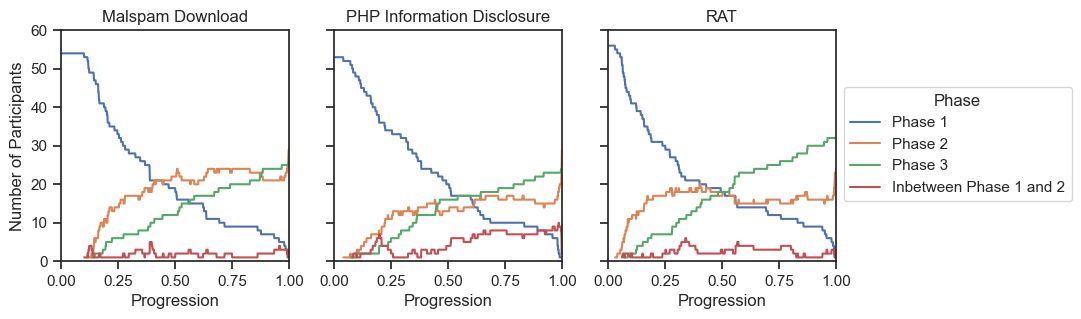

In [32]:
f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 3),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=True,
)

def get_order(phase):
    if phase == "Phase 1":
        return 1
    if phase == "Phase 2":
        return 2
    if phase == "Phase 3":
        return 3
    if phase == "Inbetween Phase 1 and 2":
        return 4
    if phase == "Inbetween Phase 2 and 3":
        return 5

handles, labels = [], []

for i, scenario in enumerate(["Malspam Download", "PHP Information Disclosure", "RAT"]):
    agg_df = (
        participant_scenario_phase_df[
            participant_scenario_phase_df["Scenario"] == scenario
        ]
        .groupby(
            [
                "Phase",
                "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF",
            ]
        )["User ID"]
        .count()
        .reset_index()
        .rename({"User ID": "Number of Participants"}, axis=1)
    )
    agg_df["SortKey"] = agg_df["Phase"].apply(get_order)
    agg_df = agg_df.sort_values(by="SortKey")
    seaborn.lineplot(
        agg_df,
        hue="Phase",
        x="Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF",
        y="Number of Participants",
        ax=axs[i],
    )
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 60)
    axs[i].set_title(scenario)
    axs[i].set_xlabel("Progression")
    
    if i == 0:
        h, l = axs[i].get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    axs[i].get_legend().remove()

f.legend(handles, labels, loc="center left", bbox_to_anchor=(0.9, 0.5), title="Phase")

f.savefig("figures/paper/phases.pdf", bbox_inches="tight", dpi=600)

In [33]:
participant_df.loc[
    participant_df["Participated"], "Best Overall F1 Visible During CTF"
].describe()

count    60.000000
mean      0.981167
std       0.067274
min       0.570000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Best Overall F1 Visible During CTF, dtype: float64

Number of sequences:  223
Number of dimensions before reduction:  16


c:\Users\20173892\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\20173892\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


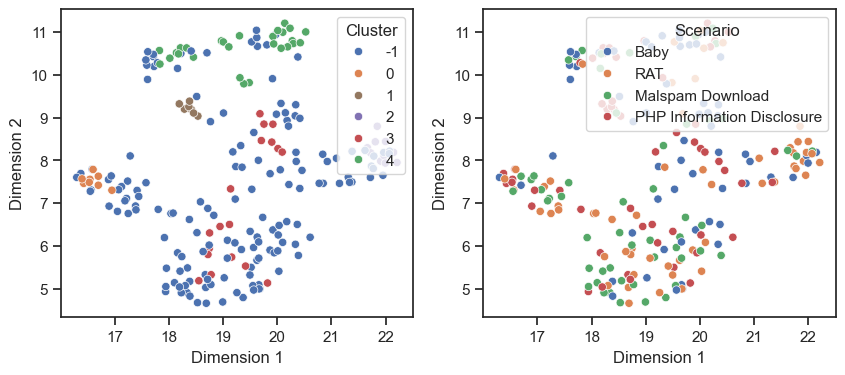

In [34]:
# Collect sequences

sequences = []
for user_id in participant_df.index:
    for scenario in rule_df["Scenario"].unique():
        mask = (
            (rule_df["User ID"] == user_id)
            & (rule_df["Scenario"] == scenario)
            & rule_df["Valid"]
            & rule_df["Submitted During CTF"]
            & ~rule_df["Multiple Rules"]
        )

        if mask.sum() == 0:
            continue

        rule_ids = rule_df[mask].index
        changes = []
        change_fields = ["Field Type"]
        for rule_id in rule_ids:
            for _, change in (
                change_df.loc[change_df["Next Rule ID"] == rule_id, change_fields]
                .sort_values(by=change_fields)
                .iterrows()
            ):
                if change["Field Type"] != "Non-Functional":
                    changes.append("|".join([str(change[x]) for x in change_fields]))
        changes = numpy.array(changes)

        # if len(changes) == 0:
        #     raise RuntimeError()

        sequences.append(
            pandas.Series({"id": str(user_id) + "|" + scenario, "sequence": changes})
        )

sequences_df = pandas.concat(sequences, axis=1).T
print("Number of sequences: ", len(sequences_df.index))

# Transform variable length sequences into fixed length vectors

model = sgt.SGT(lengthsensitive=True)

transformed_sequences: pandas.DataFrame = model.fit_transform(sequences_df)
transformed_sequences.columns = transformed_sequences.columns.map(
    lambda x: x if isinstance(x, str) else "->".join([str(y) for y in x])
)
transformed_sequences.set_index("id", inplace=True)
transformed_sequences.dropna(inplace=True)
print("Number of dimensions before reduction: ", transformed_sequences.shape[1])


# Reduce the data to 2 dimensions

# reducer = umap.UMAP(n_components=2, n_neighbors=3, metric="manhattan", random_state=0, n_jobs=1)
# reducer = umap.UMAP(n_components=2, n_neighbors=15, metric="manhattan", random_state=0, n_jobs=1)
# reducer = umap.UMAP(n_components=2, n_neighbors=40, metric="manhattan", random_state=0, n_jobs=1)
reducer = umap.UMAP(metric="manhattan", random_state=0, n_jobs=1)
reduced_results = reducer.fit_transform(transformed_sequences)
reduced_results = pandas.DataFrame(reduced_results, columns=[f"d{d}" for d in range(2)])
reduced_results["User ID"] = transformed_sequences.index.map(
    lambda x: int(x.split("|")[0])
)
reduced_results["Scenario"] = transformed_sequences.index.map(lambda x: x.split("|")[1])

# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="manhattan")
# clusters = clusterer.fit_predict(transformed_sequences)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=4)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=16, min_samples=16)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=16, min_samples=2, metric="manhattan")
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2, metric="manhattan")
# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=4, metric="manhattan")
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric="manhattan")
# clusters = clusterer.fit_predict(reduced_results[[f"d{d}" for d in range(2)]])
clusters = clusterer.fit_predict(transformed_sequences)

reduced_results["Cluster"] = [str(x) for x in clusters]

# Do the plotting

seaborn.set_theme(style="ticks")

f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 4),
    nrows=1,
    ncols=2,
    sharey=False,
    sharex=False,
)


def get_rule_column(row, col, mask):
    mask = (
        (rule_df["User ID"] == row["User ID"])
        & (rule_df["Scenario"] == row["Scenario"])
        & mask
    )
    if mask.sum() == 0:
        return numpy.nan
    return float(rule_df.loc[mask, col])


seaborn.scatterplot(
    x=reduced_results["d0"],
    y=reduced_results["d1"],
    hue=reduced_results["Cluster"],
    ax=axs[0],
)
handles, labels = axs[0].get_legend_handles_labels()
z = sorted(zip(handles, labels), key=lambda x: x[1])
handles, labels = [x[0] for x in z], [x[1] for x in z]
axs[0].legend(handles, labels, loc="upper right", title="Cluster")

seaborn.scatterplot(
    x=reduced_results["d0"],
    y=reduced_results["d1"],
    hue=reduced_results["Scenario"],
    ax=axs[1],
)
axs[1].legend(loc="upper right", title="Scenario")

for i in range(2):
    axs[i].set_xlabel("Dimension 1")
    axs[i].set_ylabel("Dimension 2")

f.savefig("figures/paper/clusters.pdf", bbox_inches="tight", dpi=600)

In [35]:
reduced_results["Cluster"].value_counts()

Cluster
-1    152
4      28
3      18
2      10
0       8
1       7
Name: count, dtype: int64

In [36]:
# TODO: USE SCENARIO IN REGRESSION FOR PREDICTING CLUSTER

C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(


-1


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

0


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

1


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["Scenario"] = plot_df["Next Rule ID"].apply(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

2


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

3


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

4


C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\1300588017.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

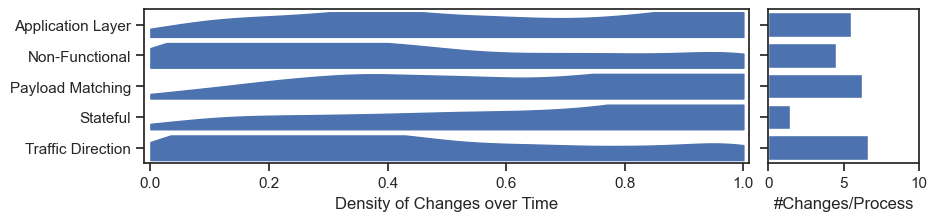

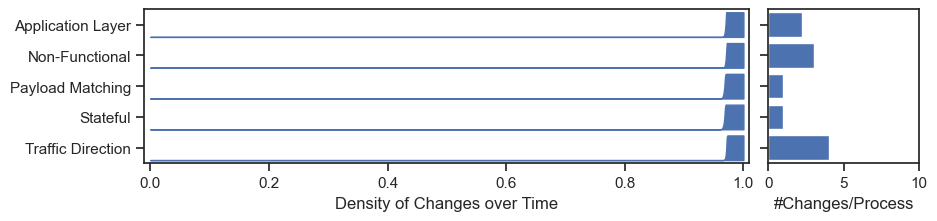

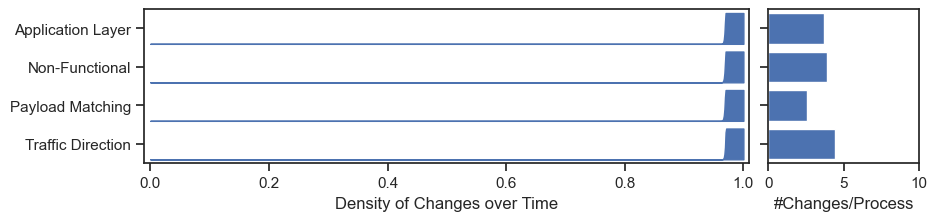

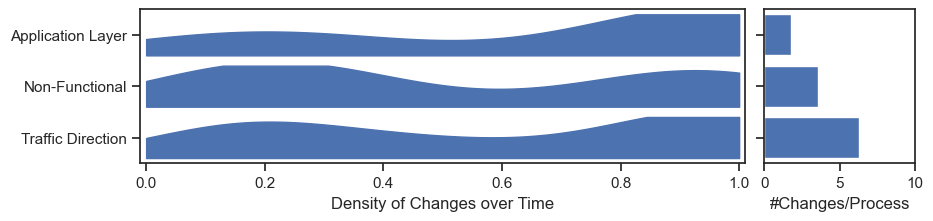

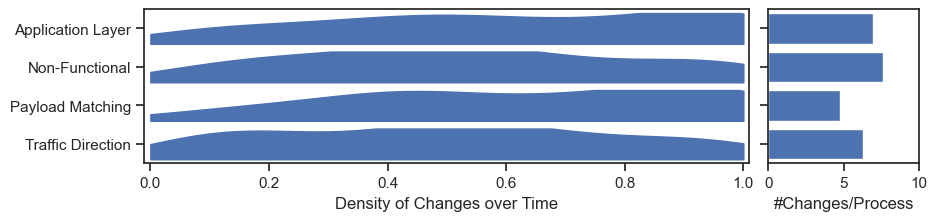

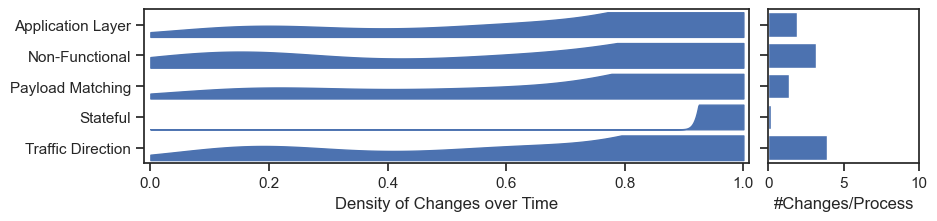

In [37]:
def get_rule_cluster(row) -> str:
    if (
        (reduced_results["User ID"] == row["User ID"])
        & (reduced_results["Scenario"] == row["Scenario"])
    ).sum() == 1:
        cluster = int(
            reduced_results.loc[
                (reduced_results["User ID"] == row["User ID"])
                & (reduced_results["Scenario"] == row["Scenario"]),
                "Cluster",
            ]
        )
        return str(cluster)
    else:
        return str(-2)


x_col = "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
y_col = "F1"

for cluster in range(-1, rule_df.apply(get_rule_cluster, axis=1).astype(int).max() + 1):
    print(cluster)
    mask = (
        (rule_df[x_col] > 0)
        & rule_df["Valid"]
        & rule_df["Submitted During CTF"]
        # & (rule_df["F1 Visible"] == 1.0)
        & (rule_df.apply(get_rule_cluster, axis=1).astype(int) == cluster)
    )

    plot_df = pandas.DataFrame()

    # Collect data for plotting
    for i, scenario in enumerate(rule_df["Scenario"].unique()):
        extra_mask = (rule_df["Scenario"] == scenario) & ~rule_df[y_col].isna()

        for user_id in rule_df.loc[mask & extra_mask, "User ID"].unique():
            extra_extra_mask = rule_df["User ID"] == user_id

            if len(rule_df.loc[mask & extra_mask & extra_extra_mask, y_col].index) == 0:
                continue

            x = rule_df.loc[mask & extra_mask & extra_extra_mask, x_col]

            new_df = pandas.DataFrame(
                {
                    x_col: x,
                    y_col: rule_df.loc[mask & extra_mask & extra_extra_mask, y_col],
                }
            )
            new_df[x_col] = pandas.to_datetime(new_df[x_col], unit="m")
            new_df = new_df.reset_index().set_index(x_col)
            new_df = new_df.resample("s", origin="epoch").bfill()
            new_df.drop(columns=["Rule ID"])
            new_df["Scenario"] = scenario
            new_df["User ID"] = user_id
            new_df = new_df.reset_index(level=x_col)
            new_df = new_df.reset_index(drop=True)

            # if new_df[y_col+ " Offset"].std() > 0.:
            #     raise RuntimeError()

            plot_df = pandas.concat([plot_df, new_df])

    def percentile(n):
        def percentile_(x):
            return x.quantile(n)

        percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
        return percentile_

    plot_df = (
        plot_df.groupby([x_col, "Scenario"])
        .agg(
            {
                y_col: [
                    "mean",
                    "median",
                    "std",
                    "count",
                    percentile(0.05),
                    percentile(0.25),
                    percentile(0.75),
                    percentile(0.95),
                ]
            }
        )
        .reset_index()
    )
    plot_df[x_col] = plot_df[x_col].apply(lambda x: x.timestamp() / 60)
    plot_df.columns = plot_df.columns.map("|".join).str.strip("|")

    # Prepare figure
    f, axs = matplotlib.pyplot.subplots(
        figsize=(10, 2),
        nrows=1,
        ncols=2,
        gridspec_kw={"width_ratios": [8, 2], "height_ratios": [7]},
        sharex=False,
        sharey=False,
    )

    # Plot changes in the main window
    plot_df = change_df[
        change_df["Next Rule ID"].apply(lambda x: x in rule_df.loc[mask, x_col].index)
    ]
    plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df.loc[x, x_col])
    plot_df["Scenario"] = plot_df["Next Rule ID"].apply(
        lambda x: rule_df.loc[x, "Scenario"]
    )

    str_category_converter = matplotlib.category.StrCategoryConverter()
    change_freqs = (
        plot_df["Field Type"].value_counts(normalize=True).sort_values(ascending=True)
    )
    unit_data = matplotlib.category.UnitData(
        sorted(change_freqs.index.to_series().unique().tolist(), reverse=True)
    )

    plot_df["Freq"] = plot_df["Field Type"].apply(lambda x: change_freqs[x])
    plot_df = plot_df.sort_values(by="Freq", ascending=True)

    # Plot density of changes on the side
    axisinfo = str_category_converter.axisinfo(unit_data, axs[1])
    axs[1].yaxis.set_major_locator(axisinfo.majloc)
    axs[1].yaxis.set_major_formatter(axisinfo.majfmt)
    counts = (
        plot_df["Field Type"].value_counts()
        / (reduced_results["Cluster"].astype(int) == cluster).sum()
    )
    # g = seaborn.barplot(y=str_category_converter.convert(counts.index, unit=unit_data, axis=axs[0]), x=counts.values, orient='h', formatter=axisinfo.majfmt, ax=axs[1], width=0.8)
    for y_loc in axisinfo.majloc():
        y_label = axisinfo.majfmt(y_loc)
        axs[1].barh(
            y_loc, counts[y_label], color=seaborn.color_palette()[0], height=0.8
        )

    # g.set(yticklabels=[])
    # g.tick_params(left=False)

    # Make actual main window plot
    axisinfo = str_category_converter.axisinfo(unit_data, axs[0])
    axs[0].yaxis.set_major_locator(axisinfo.majloc)
    axs[0].yaxis.set_major_formatter(axisinfo.majfmt)
    str_category_converter.convert(counts.index[::-1], unit=unit_data, axis=axs[0])
    # seaborn.kdeplot(x=plot_df[x_col], y=str_category_converter.convert(plot_df["Field Type"], unit=unit_data, axis=axs[0]), orient='h', color=seaborn.color_palette()[0], ax=axs[0])
    for y_loc in axisinfo.majloc():
        y_label = axisinfo.majfmt(y_loc)
        mask = plot_df["Field Type"] == y_label

        if mask.sum() <= 1.0:
            continue

        bw_method = "scott"
        kde = scipy.stats.gaussian_kde(plot_df.loc[mask, x_col], bw_method=bw_method)
        bw_adjust = 1.0
        kde.set_bandwidth(bw_method=kde.factor * bw_adjust)
        x_range = numpy.linspace(0.0, 1.0, 1000)
        y_values = kde.evaluate(x_range)
        y_values = numpy.clip(y_values, 0.0, 1.0)
        axs[0].fill_between(
            x_range,
            y_values * 0 + y_loc - 0.5 + 0.1,
            y_values * 0.8 + y_loc - 0.5 + 0.1,
            color=seaborn.color_palette()[0],
        )

    # Fix axis labels
    axs[0].set_xlabel("Density of Changes over Time")
    # axs[1].set_xlabel("Change Count per Process")
    axs[1].set_xlabel("#Changes/Process")

    # Limit x-axis
    axs[0].set_xlim(-0.01, 1.01)
    axs[1].set_xlim(-0.01, 10.01)

    axs[0].set_ylim(-0.5, max(axisinfo.majloc()) + 0.5)
    axs[1].set_ylim(-0.5, max(axisinfo.majloc()) + 0.5)

    axs[1].set_yticklabels([])

    # Fix distance between subplots
    f.subplots_adjust(hspace=0.2, wspace=0.05)

    f.savefig(
        f"figures/paper/clusters/cluster{cluster}.pdf", bbox_inches="tight", dpi=600
    )

C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\341652196.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df_pilot.loc[x, x_col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\341652196.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["Scenario"] = plot_df["Next Rule ID"].apply(
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\341652196.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

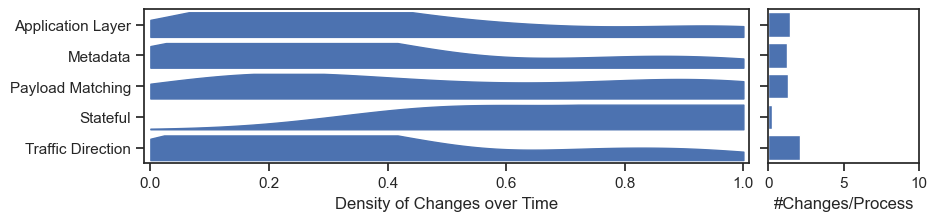

In [38]:
x_col = "Normalized Scenario Progression Towards Final Valid Submitted Rule During CTF"
y_col = "F1"

mask = (
    (rule_df_pilot[x_col] > 0)
    & rule_df_pilot["Valid"]
    & rule_df_pilot["Submitted During CTF"]
    & (
        rule_df_pilot["User ID"].isin(
            participant_df_pilot[
                participant_df_pilot["Participated"] & participant_df_pilot["Expert"]
            ].index
        )
    )
    # & (rule_df["F1 Visible"] == 1.0)
)

plot_df = pandas.DataFrame()

# Collect data for plotting
for i, scenario in enumerate(rule_df_pilot["Scenario"].unique()):
    extra_mask = (rule_df_pilot["Scenario"] == scenario) & ~rule_df_pilot[y_col].isna()

    for user_id in rule_df_pilot.loc[mask & extra_mask, "User ID"].unique():
        extra_extra_mask = rule_df_pilot["User ID"] == user_id

        if (
            len(rule_df_pilot.loc[mask & extra_mask & extra_extra_mask, y_col].index)
            == 0
        ):
            continue

        x = rule_df_pilot.loc[mask & extra_mask & extra_extra_mask, x_col]

        new_df = pandas.DataFrame(
            {
                x_col: x,
                y_col: rule_df_pilot.loc[mask & extra_mask & extra_extra_mask, y_col],
            }
        )
        new_df[x_col] = pandas.to_datetime(new_df[x_col], unit="m")
        new_df = new_df.reset_index().set_index(x_col)
        new_df = new_df.resample("s", origin="epoch").bfill()
        new_df.drop(columns=["Rule ID"])
        new_df["Scenario"] = scenario
        new_df["User ID"] = user_id
        new_df = new_df.reset_index(level=x_col)
        new_df = new_df.reset_index(drop=True)

        # if new_df[y_col+ " Offset"].std() > 0.:
        #     raise RuntimeError()

        plot_df = pandas.concat([plot_df, new_df])


def percentile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "percentile_{:02.0f}".format(n * 100)
    return percentile_


plot_df = (
    plot_df.groupby([x_col, "Scenario"])
    .agg(
        {
            y_col: [
                "mean",
                "median",
                "std",
                "count",
                percentile(0.05),
                percentile(0.25),
                percentile(0.75),
                percentile(0.95),
            ]
        }
    )
    .reset_index()
)
plot_df[x_col] = plot_df[x_col].apply(lambda x: x.timestamp() / 60)
plot_df.columns = plot_df.columns.map("|".join).str.strip("|")

# Prepare figure
f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 2),
    nrows=1,
    ncols=2,
    gridspec_kw={"width_ratios": [8, 2], "height_ratios": [7]},
    sharex=False,
    sharey=False,
)

# Plot changes in the main window
plot_df = change_df_pilot[
    change_df_pilot["Next Rule ID"].apply(
        lambda x: x in rule_df_pilot.loc[mask, x_col].index
    )
]
plot_df[x_col] = plot_df["Next Rule ID"].apply(lambda x: rule_df_pilot.loc[x, x_col])
plot_df["Scenario"] = plot_df["Next Rule ID"].apply(
    lambda x: rule_df_pilot.loc[x, "Scenario"]
)

str_category_converter = matplotlib.category.StrCategoryConverter()
change_freqs = (
    plot_df["Field Type"].value_counts(normalize=True).sort_values(ascending=True)
)
unit_data = matplotlib.category.UnitData(
    sorted(change_freqs.index.to_series().unique().tolist(), reverse=True)
)

plot_df["Freq"] = plot_df["Field Type"].apply(lambda x: change_freqs[x])
plot_df = plot_df.sort_values(by="Freq", ascending=True)

# Plot density of changes on the side
axisinfo = str_category_converter.axisinfo(unit_data, axs[1])
axs[1].yaxis.set_major_locator(axisinfo.majloc)
axs[1].yaxis.set_major_formatter(axisinfo.majfmt)
counts = (
    plot_df["Field Type"].value_counts()
    / (reduced_results["Cluster"].astype(int) == cluster).sum()
)
# g = seaborn.barplot(y=str_category_converter.convert(counts.index, unit=unit_data, axis=axs[0]), x=counts.values, orient='h', formatter=axisinfo.majfmt, ax=axs[1], width=0.8)
for y_loc in axisinfo.majloc():
    y_label = axisinfo.majfmt(y_loc)
    axs[1].barh(y_loc, counts[y_label], color=seaborn.color_palette()[0], height=0.8)


# g.set(yticklabels=[])
# g.tick_params(left=False)

# Make actual main window plot
axisinfo = str_category_converter.axisinfo(unit_data, axs[0])
axs[0].yaxis.set_major_locator(axisinfo.majloc)
axs[0].yaxis.set_major_formatter(axisinfo.majfmt)
str_category_converter.convert(counts.index[::-1], unit=unit_data, axis=axs[0])
# seaborn.kdeplot(x=plot_df[x_col], y=str_category_converter.convert(plot_df["Field Type"], unit=unit_data, axis=axs[0]), orient='h', color=seaborn.color_palette()[0], ax=axs[0])
for y_loc in axisinfo.majloc():
    y_label = axisinfo.majfmt(y_loc)
    mask = plot_df["Field Type"] == y_label

    if mask.sum() <= 0.0:
        continue

    bw_method = "scott"
    kde = scipy.stats.gaussian_kde(plot_df.loc[mask, x_col], bw_method=bw_method)
    bw_adjust = 1.0
    kde.set_bandwidth(bw_method=kde.factor * bw_adjust)
    x_range = numpy.linspace(0.0, 1.0, 1000)
    y_values = kde.evaluate(x_range)
    y_values = numpy.clip(y_values, 0.0, 1.0)
    axs[0].fill_between(
        x_range,
        y_values * 0 + y_loc - 0.5 + 0.1,
        y_values * 0.8 + y_loc - 0.5 + 0.1,
        color=seaborn.color_palette()[0],
    )

# Fix axis labels
axs[0].set_xlabel("Density of Changes over Time")
# axs[1].set_xlabel("Change Count per Process")
axs[1].set_xlabel("#Changes/Process")

# Limit x-axis
axs[0].set_xlim(-0.01, 1.01)
axs[1].set_xlim(-0.01, 10.01)

axs[0].set_ylim(-0.5, max(axisinfo.majloc()) + 0.5)
axs[1].set_ylim(-0.5, max(axisinfo.majloc()) + 0.5)

axs[1].set_yticklabels([])

# Fix distance between subplots
f.subplots_adjust(hspace=0.2, wspace=0.05)

f.savefig("figures/paper/expert_cluster.pdf", bbox_inches="tight", dpi=600)

In [39]:
reduced_results["F1"] = reduced_results.apply(
    lambda row: get_rule_column(row, "F1", rule_df["Final Best Submission During CTF"]),
    axis=1,
)
reduced_results["Precision"] = reduced_results.apply(
    lambda row: get_rule_column(
        row, "Precision", rule_df["Final Best Submission During CTF"]
    ),
    axis=1,
)
reduced_results["Recall"] = reduced_results.apply(
    lambda row: get_rule_column(
        row, "Recall", rule_df["Final Best Submission During CTF"]
    ),
    axis=1,
)
reduced_results["Unneccessary Workload"] = reduced_results.apply(
    lambda row: get_rule_column(
        row, "Unneccessary Workload", rule_df["Final Best Submission During CTF"]
    ),
    axis=1,
)
reduced_results["Seconds Worked Towards Scenario Submission"] = reduced_results.apply(
    lambda row: get_rule_column(
        row,
        "Seconds Worked Towards Scenario Submission",
        rule_df["First Submission to Pass Visible Tests During CTF"],
    ),
    axis=1,
)
reduced_results["Design Principle Issues Count"] = reduced_results.apply(
    lambda row: get_rule_column(
        row,
        "Design Principle Issues Count",
        rule_df["Final Best Submission During CTF"],
    ),
    axis=1,
)
reduced_results["Number of Rules"] = reduced_results["User ID"].apply(
    lambda x: participant_df.loc[x, "Number of Rules"]
)
reduced_results["Fraction of Valid Rules"] = reduced_results["User ID"].apply(
    lambda x: participant_df.loc[x, "Fraction of Valid Rules"]
)
reduced_results["Number of Valid Rules"] = reduced_results["User ID"].apply(
    lambda x: participant_df.loc[x, "Number of Valid Rules"]
)
reduced_results["Number of Invalid Rules"] = reduced_results["User ID"].apply(
    lambda x: participant_df.loc[x, "Number of Invalid Rules"]
)

C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\2661245450.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rule_df.loc[mask, col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\2661245450.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rule_df.loc[mask, col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\2661245450.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rule_df.loc[mask, col])
C:\Users\20173892\AppData\Local\Temp\ipykernel_38644\2661245450.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rule_df.

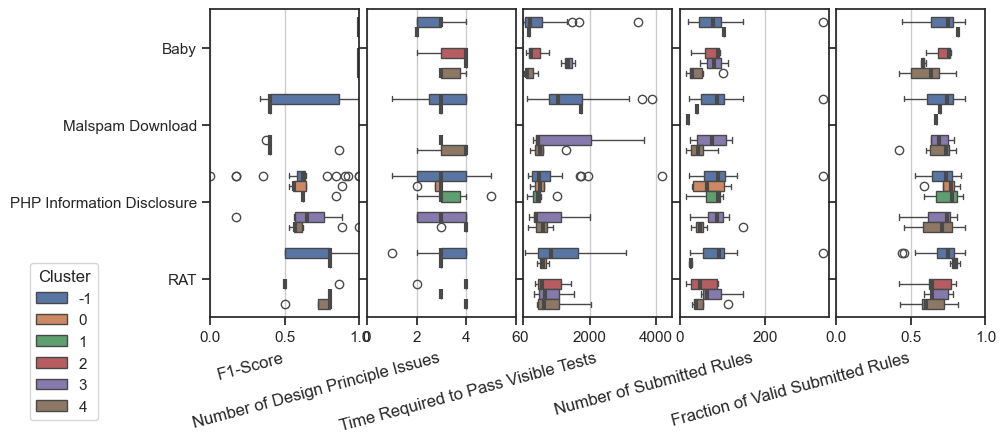

In [40]:
x_cols = [
    "F1",
    # "Precision",
    # "Recall",
    # "Unneccessary Workload",
    "Design Principle Issues Count",
    "Seconds Worked Towards Scenario Submission",
    "Number of Rules",
    "Fraction of Valid Rules",
    # "Number of Valid Rules",
    # "Number of Invalid Rules",
]

ROTATION = 15

seaborn.set_theme(style="ticks")

mask = participant_df["Participated"]
# mask = mask & participant_df["Watched Lecture Before CTF"]

f, axs = matplotlib.pyplot.subplots(
    figsize=(10, 4), nrows=1, ncols=len(x_cols), sharey=True, sharex=False
)

reduced_results.sort_values(by=["Cluster", "Scenario"], inplace=True)
# Plot the effects of the clusters
for i, x_col in enumerate(x_cols):
    ax = axs[i]
    seaborn.boxplot(
        data=reduced_results.drop(columns=[f"d{d}" for d in range(2)]),
        x=x_col,
        y="Scenario",
        hue="Cluster",
        hue_order=numpy.array(
            range(-1, reduced_results["Cluster"].astype(int).max() + 1)
        ).astype(str),
        orient="h",
        # whis=(0, 100),
        medianprops={"linewidth": 3},
        ax=ax,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    ax.get_legend().remove()
    # ax.set_xlim(0, 1)

# axs[1].set_xscale("log")

axs[0].set_xlim(0.0, 1.0)
axs[1].set_xlim(0, 6)
axs[2].set_xlim(0, 4500)
axs[3].set_xlim(0, 350)
axs[4].set_xlim(0.0, 1.0)

axs[0].set_xlabel("F1-Score", rotation=ROTATION, ha="right")
axs[1].set_xlabel("Number of Design Principle Issues", rotation=ROTATION, ha="right")
axs[2].set_xlabel("Time Required to Pass Visible Tests", rotation=ROTATION, ha="right")
axs[3].set_xlabel("Number of Submitted Rules", rotation=ROTATION, ha="right")
axs[4].set_xlabel("Fraction of Valid Submitted Rules", rotation=ROTATION, ha="right")

axs[0].legend(bbox_to_anchor=(-0.7, 0.2), title="Cluster")

f.subplots_adjust(hspace=0.2, wspace=0.05)

# seaborn.despine(trim=True, left=True)

f.savefig("figures/paper/clusters_comparison.pdf", bbox_inches="tight", dpi=600)

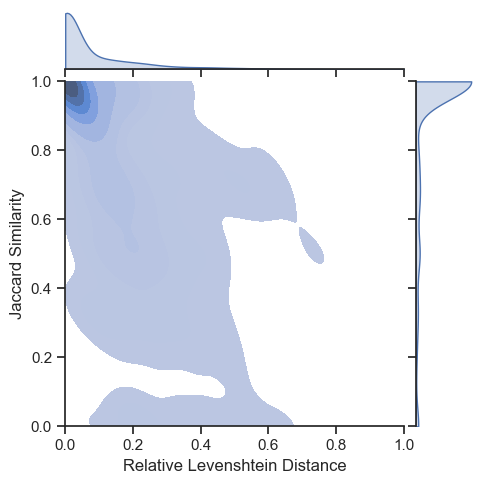

In [41]:
update_df["Relative Levenshtein Distance"] = update_df.apply(
    lambda row: (
        row["Levenshtein Distance"] / len(row["Previous Rule"])
        if not pandas.isna(row["Previous Rule"])
        else numpy.nan
    ),
    axis=1,
)

jg = seaborn.jointplot(
    update_df,
    x="Relative Levenshtein Distance",
    y="Jaccard Similarity",
    kind="kde",
    fill=True,
    common_norm=False,
    clip=((0, 1), (0, 1)),
    marginal_kws={"clip": (0, 1)},
    height=5,
)

jg.savefig("figures/paper/finetuning.pdf", bbox_inches="tight", dpi=600)